# 数据加载和处理
当我们着手解决于机器学习问题时，我们大量的时间都会被花在准备数据中。PyTorch 提供了大量的工具使得数据加载变得容易，使得代码的可读性变强。在这个教程里我们将学会加载一些重要的数据集并做好预处理、增强。

为了能够跑这个教程里的代码，请你确认自己的系统安装了以下包：
1. scikit-image: 图片的输入输出和变换
2. pandas：使得 csv 解析变得容易

In [34]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

我们处理的数据集为脸部姿态（facial pose）。脸部姿态意思是一张脸被标注成下面的模样：
<img src="https://pytorch.org/tutorials/_images/landmarked_face2.png" align="left" width=380 height=380>

总共有68个可标注的点（每张脸）。
**注意：**
从[这里](https://download.pytorch.org/tutorial/faces.zip)下载数据。数据是放在一个叫‘faces/’的文件夹下。这个数据集其实来自imagenet中标记为脸的数据，通过应用[dlib’s pose estimation](http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html)产生。

数据集中有 csv 文件带有如下的注释：
```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```
让我们快速阅读下 CSV 然后获得（N, 2) 数组。N 代表第几张图片。

In [35]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


让我们写一个简单的帮助方法来显示一张图片以及它的 landmarks。然后用这个方法来显示一个样本。

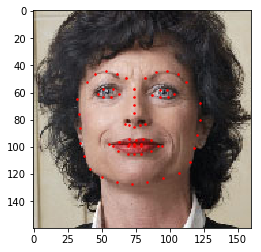

In [36]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker=".", c="r")
    plt.pause(0.001)  # pause a bit so that plots are updated
    
plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

## Dataset 类（Dataset class）
<font color=red>torch.utils.data.Dataset</font> 是一个代表数据集的抽象类。你自定义的数据集必须继承 Dataset 类，然后重载复写下面的方法：

1. <font color=red>__len__</font>: 这样使得我们可以用 <font color=red>len(dataset)</font> 返回我们数据集的大小（长度）。
2. <font color=red>__getitem__</font>: 这个方法使得我们可以通过 <font color=red>dataset[i]</font> 来获取数据集的第 i 个样本。

让我们为我们的 face landmarks dataset 创建一个数据集的类。我们在 <font color=red>__init__</font> 中读取 csv 文件但不读图片。图片的读取留给 <font color=red>__getitem__</font> 方法。这样做能节省内存。因为所有的图片并没有直接读取存在内存里，而是在需要的时候才被读取。

我们的数据集将是一个字典 <font color=red>{'image': image, 'landmarks': landmarks}</font>。我们的数据集可以接受一个可选参数 <font color=red>transform</font>。这样我们就可以给我们的样本加上想要的处理。我们将在下面章节的介绍中发现 <font color=red>transform</font> 的作用。

In [37]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
               on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0]) # path to idx image
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

让我们实例化这个类然后迭代这个数据集。我们打印出前4个样本并且显示他们的 landmarks。

0 (324, 215, 3) (68, 2)


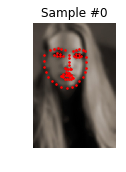

1 (500, 333, 3) (68, 2)


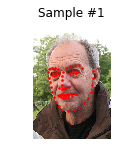

2 (250, 258, 3) (68, 2)


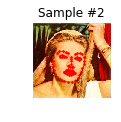

3 (434, 290, 3) (68, 2)


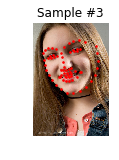

In [38]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## 转换（Transforms)
我们可以发现数据集中的图像尺寸不同。大部分的神经网络都希望输入是固定大小的。因此，我们需要前处理（preprocessing）的代码。让我们来创建三个转换（transforms）：
1. <font color=red>Rescale</font>：保证图片大小（to scale the image）。
2. <font color=red>RandomCrop</font>：随机裁剪(corp randomly)图片。这是在做图片增强(augmentation)。
3. <font color=red>ToTensor</font>：将 numpy 图像转换为 torch 图像（我们需要轴变换）。

我们想写可以调用的类而不是简单的函数。这样就可以避免每次调用变换方法时都需要传入参数。我们只需要实现 <font color=red>__call__</font> 方法，必要时还需要实现 <font color=red>__init__</font> 方法。我们可以像下面这样使用变换（transform）：
```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```
观察一下下面实现的转换是如何同时对图像（image）和 landmarks 进行处理。

In [39]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### 转换组合（Compose transform)
现在，让我们给一个样本加上变换。

我们想把图片的短边规范为 256。接着对它进行大小为 224 的随机剪裁。我们想把 <font color=red>Rescale</font> 和 <font color=red>RandomCrop</font> 进行组合（compose）。<font color=red>torchvision.transforms.Compose</font> 可以让我们做到这一点的一个可以调用的类（callable class）。

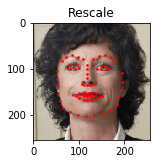

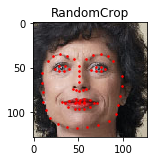

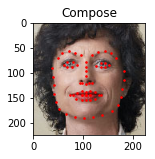

In [40]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## 迭代数据集（Iterating through the dataset）
现在我们综合之前的数据集并加上组合过的转换（composed transforms）。总结如下，数据集每次被采取出来的样本：
1. 图像从文件中被读取
2. 读取出来的图片加上咱们的转换
3. 由于咱们的一个转换是随机的，所以数据在采样过程中被增强了

我们可以像之前一样用 for i in range 的循环来迭代我们的数据集。

In [41]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256), 
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['landmarks'].size())
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


然而用 for 循环来迭代我们的数据集会丢失掉很多特征信息。特别是一下几个方面：
1. 批量化我们的数据（Batching the data）
2. 随机打乱我们的数据（Shuffling the data)
3. 用 <font color=red>multiprocessing</font> 并行加载我们的数据（Load the data in paralleling using <font color=red>multiprocessing</font> workers）

<font color=red>torch.utils.data.DataLoader</font> 是一个可以提供上述所有功能的迭代器。在下面的例子中，所有的参数用意都很清晰。有一个参数是 <font color=red>collate_fn</font>。你可以通过 <font color=red>collate_fn</font> 来确定把怎样的数据捆绑一起成为一个批量。但是默认的 collate 已经能够胜任大部分的情景了。

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


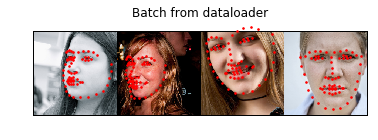

In [53]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)  # the width of image

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## 后记：torchvision
在本教程中，你知道了如何写如何用数据集（datasets），转换（transforms）还有数据装载器（dataloader）。<font color=red>torchvision</font> 包提供了很多常用的数据集（datasets）和变换（transforms）。你甚至不需要自己写自定义的类（classes）。<font color=red>ImageFolder</font> 是 torchvision 中一个通用的类。它假设图片是按照下面的方式组织的：
```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```
这里的’ants‘，’bees‘等等是类的标签（class labels）。还有通用的一些可以用在 <font color=red>PIL.Image
</font> 的变换（transforms）如 <font color=red>RandomHorizontalFlip</font>，<font color=red>Scale</font> 等也在包中实现了。你可以利用这些写一个数据装载器（dataloader）如下所示：

In [56]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)